In [1]:
%load_ext autoreload
%autoreload 2
%set_env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


## Setup

In [58]:
from collections.abc import Callable
import pandas as pd
import seaborn as sns
import math

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer
from datasets import Dataset, load_dataset
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
from typing import Optional, Tuple
from jaxtyping import Float
from abc import ABC, abstractmethod
from dataclasses import dataclass
from random import choice, shuffle
from typing import final, cast
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F
import random
import gc
from sklearn.feature_selection import mutual_info_regression


from teren.utils import get_device_str, setup_determinism

In [59]:
def clean_cache():
    torch.cuda.empty_cache()
    gc.collect()

In [60]:
# Utils
def generate_prompt(dataset, n_ctx: int = 1, batch: int = 1) -> torch.Tensor:
    """Generate a prompt from the dataset."""
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)
    return next(iter(dataloader))["input_ids"][:, :n_ctx]


def compute_kl_div(logits_ref: torch.Tensor, logits_pert: torch.Tensor) -> torch.Tensor:
    """Compute the KL divergence between the reference and perturbed logprobs."""
    logprobs_ref = F.log_softmax(logits_ref, dim=-1)
    logprobs_pert = F.log_softmax(logits_pert, dim=-1)
    temp_output = F.kl_div(
        logprobs_pert, logprobs_ref, log_target=True, reduction="none"
    )
    return temp_output.sum(dim=-1)


def get_random_activation(
    model: HookedTransformer, dataset: Dataset, n_ctx: int, layer: str, pos
) -> torch.Tensor:
    """Get a random activation from the dataset."""
    rand_prompt = generate_prompt(dataset, n_ctx=n_ctx)
    _, cache = model.run_with_cache(rand_prompt)
    return cache[layer][:, pos, :].to("cpu").detach()


def load_pretokenized_dataset(
    path: str,
    split: str,
) -> Dataset:
    dataset = load_dataset(path, split=split)
    dataset = cast(Dataset, dataset)
    return dataset.with_format("torch")

In [61]:
@dataclass
class ExperimentConfig:
    n_ctx: int
    perturbation_layer: str
    read_layer: str
    perturbation_pos: slice
    n_steps: int
    perturbation_range: Tuple[float, float]
    seed: Optional[int] = None
    dataloader_batch_size: Optional[int] = None
    mean_batch_size: Optional[int] = None


class Reference:
    def __init__(
        self,
        model: HookedTransformer,
        prompt: torch.Tensor,
        perturbation_layer: str,
        read_layer: str,
        perturbation_pos: slice,
        n_ctx: int,
    ):
        self.model = model
        _, n_ctx_prompt = prompt.shape
        assert (
            n_ctx == n_ctx_prompt
        ), f"n_ctx {n_ctx} must match prompt n_ctx {n_ctx_prompt}"
        self.prompt = prompt
        logits, cache = model.run_with_cache(prompt)
        self.logits = logits.to("cpu").detach()
        self.cache = cache.to("cpu")
        self.act = self.cache[perturbation_layer][:, perturbation_pos]
        self.perturbation_layer = perturbation_layer
        self.read_layer = read_layer
        self.perturbation_pos = perturbation_pos
        self.n_ctx = n_ctx

In [62]:
@dataclass(kw_only=True)
class Perturbation(ABC):
    @final
    def __call__(
        self, resid_acts: Float[torch.Tensor, "... n_ctx d_model"]
    ) -> Float[torch.Tensor, "... n_ctx d_model"]:
        """Ensures that all generate method has correct signature with beartype"""
        return self.generate(resid_acts)

    @abstractmethod
    def generate(self, resid_acts: Float[torch.Tensor, "... n_ctx d_model"]):
        raise NotImplementedError


@dataclass
class NaiveRandomPerturbation(Perturbation):
    """Isotropic random"""

    def generate(self, resid_acts):
        return torch.randn(resid_acts.shape)


@dataclass
class RandomPerturbation(Perturbation):
    """Scaled random"""

    def __init__(self, data_mean, data_cov):
        self.distrib = MultivariateNormal(data_mean.squeeze(0), data_cov)

    def generate(self, resid_acts):
        target = self.distrib.sample(resid_acts.shape[:-1])
        return target - resid_acts


@dataclass
class RandomActivationPerturbation(Perturbation):
    """Random activation direction"""

    def __init__(self, base_ref, dataset):
        self.base_ref = base_ref
        self.dataset = dataset

    def generate(self, resid_acts):
        target = get_random_activation(
            self.base_ref.model,
            self.dataset,
            self.base_ref.n_ctx,
            self.base_ref.perturbation_layer,
            self.base_ref.perturbation_pos,
        )
        return target - resid_acts


@dataclass
class ControlledActivationPerturbation(Perturbation):
    def __init__(self, base_ref, prompt):
        self.base_ref = base_ref
        self.prompt = prompt

    def generate(self, resid_acts):
        model = self.base_ref.model
        pos = self.base_ref.perturbation_pos
        layer = self.base_ref.perturbation_layer

        controlled_prompt = torch.tensor([model.tokenizer.encode(self.prompt)])
        _, cache = self.base_ref.model.run_with_cache(controlled_prompt)

        target = cache[layer][:, pos, :].to("cpu").detach()
        return target - resid_acts


@dataclass
class SAEFeatureAblationPerturbation(Perturbation):
    def __init__(self, base_ref, sae):
        self.base_ref = base_ref
        self.sae = sae

    def generate(self, resid_acts):
        feature_acts = self.sae.encode(self.base_ref.act.squeeze())
        ablate_feature_id = torch.argmax(feature_acts)
        feature_acts[ablate_feature_id] = 0
        perturbed_act = self.sae.decode(feature_acts)
        return perturbed_act - resid_acts


@dataclass
class SAEFeaturesAblationPerturbation(Perturbation):
    def __init__(self, base_ref, sae, ablate_feature_ids):
        self.base_ref = base_ref
        self.sae = sae
        self.ablate_feature_ids = ablate_feature_ids

    def generate(self, resid_acts):
        feature_acts = self.sae.encode(self.base_ref.act.squeeze())
        feature_acts[self.ablate_feature_ids] = 0
        perturbed_act = self.sae.decode(feature_acts)
        return perturbed_act - resid_acts


@dataclass
class RandomSensitiveDirectionPerturbation(Perturbation):
    def __init__(self, base_ref, dataset, sae, top_k=3):
        self.base_ref = base_ref
        self.dataset = dataset
        self.sae = sae
        self.top_k = top_k

    def get_top_features_ablated_direction(self, acts):
        feature_acts = self.sae.encode(acts)
        active_feature_ids = (feature_acts > 0).nonzero().squeeze()
        sorted_indices = torch.argsort(
            feature_acts[active_feature_ids], descending=True
        )
        sorted_active_feature_ids = active_feature_ids[sorted_indices]
        to_ablate_feature_ids = sorted_active_feature_ids[: self.top_k]
        feature_acts[to_ablate_feature_ids] = 0
        perturbed_act = self.sae.decode(feature_acts)
        return perturbed_act

    def get_top_features_direction(self, acts):
        feature_acts = self.sae.encode(acts)
        active_feature_ids = (feature_acts > 0).nonzero().squeeze()
        sorted_indices = torch.argsort(
            feature_acts[active_feature_ids], descending=True
        )
        sorted_active_feature_ids = active_feature_ids[sorted_indices]
        to_ablate_feature_ids = sorted_active_feature_ids[self.top_k :]
        feature_acts[to_ablate_feature_ids] = 0
        perturbed_act = self.sae.decode(feature_acts)
        return perturbed_act

    def generate(self, resid_acts):
        ablated_acts = self.get_top_features_ablated_direction(resid_acts.squeeze())
        target_acts = get_random_activation(
            self.base_ref.model,
            self.dataset,
            self.base_ref.n_ctx,
            self.base_ref.perturbation_layer,
            self.base_ref.perturbation_pos,
        )
        target_acts = self.get_top_features_direction(target_acts.squeeze())
        return ablated_acts - resid_acts + target_acts


@dataclass
class SAEDecoderDirectionPerturbation(Perturbation):
    def __init__(
        self, base_ref: Reference, unrelated_ref: Reference, sae, negate=-1, thresh=0.1
    ):
        self.base_ref = base_ref
        self.unrelated_ref = unrelated_ref
        self.sae = sae
        self.negate = negate
        self.thresh = thresh
        self.feature_acts = sae.encode(base_ref.cache[sae.cfg.hook_name])[0, -1, :]
        self.active_features = (
            self.feature_acts / self.feature_acts.max() > self.thresh
        ).to("cpu")

    def generate(self, resid_acts):
        chosen_feature_idx = choice(self.active_features.nonzero(as_tuple=True)[0])
        single_dir = (
            self.negate * self.sae.W_dec[chosen_feature_idx, :].to("cpu").detach()
        )

        if isinstance(self.base_ref.perturbation_pos, slice):
            dir = torch.stack(
                [single_dir for _ in range(self.base_ref.act.shape[0])]
            ).unsqueeze(0)
        else:
            dir = single_dir.unsqueeze(0)

        scale = self.feature_acts[chosen_feature_idx]
        return dir * scale


@dataclass
class SAEFeaturePerturbation(Perturbation):
    def __init__(self, base_ref: Reference, chosen_feature, sae, negate=-1):
        self.base_ref = base_ref
        self.sae = sae
        self.negate = negate
        self.feature_idx, self.feature_act = chosen_feature

    def generate(self, resid_acts):
        single_dir = (
            self.negate * self.sae.W_dec[self.feature_idx, :].to("cpu").detach()
        )

        if isinstance(self.base_ref.perturbation_pos, slice):
            dir = torch.stack(
                [single_dir for _ in range(self.base_ref.act.shape[0])]
            ).unsqueeze(0)
        else:
            dir = single_dir.unsqueeze(0)

        scale = self.feature_act
        return dir * scale

In [63]:
def run_perturbed_activation(
    base_ref: Reference,
    perturbed_activations: Float[torch.Tensor, "... n_steps 1 d_model"],
):
    def hook(act, hook):
        act[:, base_ref.perturbation_pos, :] = perturbed_activations

    with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
        prompts = torch.cat(
            [base_ref.prompt for _ in range(len(perturbed_activations))]
        )
        logits_pert, cache = base_ref.model.run_with_cache(prompts)

    return logits_pert.to("cpu").detach(), cache.to("cpu")


def compare(
    base_ref: Reference,
    perturbed_activations: Float[torch.Tensor, "... n_steps 1 d_model"],
) -> Float[torch.Tensor, "n_steps"]:
    logits_pert, _ = run_perturbed_activation(base_ref, perturbed_activations)
    kl_div = compute_kl_div(base_ref.logits, logits_pert)[
        :, base_ref.perturbation_pos
    ].squeeze(-1)
    return kl_div


def scan(
    perturbation: Perturbation,
    activations: Float[torch.Tensor, "... n_ctx d_model"],
    n_steps: int,
    range: tuple[float, float],
) -> Float[torch.Tensor, "... n_steps 1 d_model"]:
    direction = perturbation(activations)
    direction -= torch.mean(direction, dim=-1, keepdim=True)

    # act_norm = torch.linalg.vector_norm(activations, dim=-1, keepdim=True)
    # dir_norm = torch.linalg.vector_norm(direction, dim=-1, keepdim=True)
    # scale = act_norm / dir_norm
    # direction *= scale

    perturbed_steps = [
        activations + alpha * direction for alpha in torch.linspace(*range, n_steps)
    ]
    perturbed_activations = torch.cat(perturbed_steps, dim=0)
    return perturbed_activations


def run_perturbation(
    cfg: ExperimentConfig, base_ref: Reference, perturbation: Perturbation
):
    perturbed_activations = scan(
        perturbation=perturbation,
        activations=base_ref.act,
        n_steps=cfg.n_steps,
        range=cfg.perturbation_range,
    )
    kl_div = compare(base_ref, perturbed_activations)
    return kl_div

In [64]:
cfg = ExperimentConfig(
    n_ctx=16,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=6,
    dataloader_batch_size=16,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0, 1),
    n_steps=100,
    mean_batch_size=512,
)

In [65]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


# setup_determinism(cfg.seed)
set_seed(cfg.seed)

In [66]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [67]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [68]:
saes, sparsities = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
sparsity = sparsities[cfg.perturbation_layer].cpu()

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


## Choosing prompt

In [13]:
# Set up hand crafted prompt

# less of a spread over next tokens
easy_completions = [
    "Water boils at 212 degrees",
    "The capital of France is",
    "To be or not to be, that is the",
    "Water boils at 100",
    "The Earth revolves around the",
]

# more of a spread over next tokens
harder_completions = [
    "The next big technological breakthrough will be in the field of",
    "In the year 2050, the most popular form of transportation will be",
    "The best way to solve climate change is to",
    "The next word in this sentence is",
]

# prompts potentially eliciting interesting feature activations
feature_completions = [
    "The quantum computer calculated the result in mere",
    "The AI system's ethical subroutines conflicted with its primary directive, causing it to"
    "The ancient artifact, when exposed to moonlight, began to",
]

base_prompt_text = easy_completions[0]
base_prompt = torch.tensor([model.tokenizer.encode(base_prompt_text)])

print(base_prompt_text)
print(base_prompt)

Water boils at 212 degrees
tensor([[19184, 40169,   379, 23679,  7370]])


In [14]:
# generate random prompt
base_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
base_prompt_text = model.tokenizer.batch_decode(base_prompt)
print(base_prompt_text)

base_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    base_prompt.shape[1],
)

["Make America Great Again' cap.\n\nAnd when Scaramucci sold his"]


In [15]:
base_prompt

tensor([[12050,  2253,  3878,  6521,     6,  1451,    13,   198,   198,  1870,
           618, 12089,   321, 27501,  2702,   465]])

In [16]:
# Sanity check
def get_most_likely_token(logits, tokenizer, top_k=5):
    logits = logits[0, -1, :]
    probs = torch.softmax(logits, dim=-1)
    top_k_probs, top_k_indices = torch.topk(probs, k=top_k)

    for prob, index in zip(top_k_probs, top_k_indices):
        token = tokenizer.decode([index])
        print(f"Token: '{token}', Probability: {prob.item():.4f}")

    return tokenizer.decode([top_k_indices[0]])


# Using your model (assuming it's called base_ref)
prompt = base_prompt_text
inputs = base_ref.model.tokenizer(prompt, return_tensors="pt")

print(f"Prompt: {prompt}")
most_likely = get_most_likely_token(base_ref.logits, base_ref.model.tokenizer)
print(f"Most likely next token: '{most_likely}'")

Prompt: ["Make America Great Again' cap.\n\nAnd when Scaramucci sold his"]
Token: ' stake', Probability: 0.0587
Token: ' own', Probability: 0.0232
Token: ' role', Probability: 0.0136
Token: ' position', Probability: 0.0124
Token: ' company', Probability: 0.0121
Most likely next token: ' stake'


## Running perturbations (naive random, random, r-other, sae)

In [17]:
# Some experiment specific utils for converting a cov matrix
# to positive definite (we suspect it's because of smaller
# batch size) needed for MultivariateNormal
def is_positive_definite(A):
    try:
        torch.linalg.cholesky(A)
        return True
    except RuntimeError:
        return False


def nearest_positive_definite(A):
    B = (A + A.T) / 2
    _, s, V = torch.svd(B)
    H = V.mm(torch.diag(s).mm(V.T))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    if is_positive_definite(A3):
        return A3
    spacing = np.geomspace(torch.finfo(A.dtype).eps, 1, 10)
    for i in range(len(spacing)):
        mineig = torch.min(torch.real(torch.linalg.eigvals(A3)))
        A3 += torch.eye(A.shape[0]) * (-mineig * (1 + spacing[i]))
        if is_positive_definite(A3):
            return A3
    return A3

In [18]:
batch_of_prompts = generate_prompt(dataset, n_ctx=cfg.n_ctx, batch=cfg.mean_batch_size)
batch_act_cache = model.run_with_cache(batch_of_prompts)[1].to("cpu")
data = batch_act_cache[cfg.perturbation_layer][:, cfg.perturbation_pos, :].squeeze(1)

print(data.shape)

data_mean = data.mean(dim=0, keepdim=True)
data_cov = (
    torch.einsum("i j, i k -> j k", data - data_mean, data - data_mean) / data.shape[0]
)

torch.Size([512, 768])


In [19]:
# substitute covariance matrix with nearest that is positive definite
if not is_positive_definite(data_cov):
    print("cov matrix is not positive definite, tweaking..")
    data_cov = nearest_positive_definite(data_cov)

cov matrix is not positive definite, tweaking..


In [20]:
unrelated_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)

unrelated_ref = Reference(
    model,
    unrelated_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    cfg.n_ctx,
)

In [21]:
naive_random_perturbation = NaiveRandomPerturbation()
random_perturbation = RandomPerturbation(data_mean, data_cov)
random_activation_perturbation = RandomActivationPerturbation(base_ref, dataset)
saedir_perturbation = SAEDecoderDirectionPerturbation(
    base_ref, unrelated_ref, sae, negate=-1, thresh=0
)

controlled_other_prompt = "Water freezes at 0 degrees"
controlled_activation_perturbation = ControlledActivationPerturbation(
    base_ref, controlled_other_prompt
)

random_sensitivite_direction_perturbation = RandomSensitiveDirectionPerturbation(
    base_ref, dataset, sae
)

perturbations = {
    "naive random": naive_random_perturbation,
    "random": random_perturbation,
    "random other activation": random_activation_perturbation,
    # "negative active SAE decoder feature": saedir_perturbation,
    # "controlled other activation": controlled_activation_perturbation,
    # "sensitive random": random_sensitivite_direction_perturbation
}

In [22]:
results = defaultdict(list)

for _ in tqdm(range(10)):
    for name, perturbation in perturbations.items():
        kl_div = run_perturbation(cfg, base_ref, perturbation)
        results[name].append(kl_div)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


In [56]:
sae_top_feature_ablation_perturbation = SAEFeatureAblationPerturbation(base_ref, sae)

# Pareto optimal features (largest KL div)
ablate_feature_ids = [15900, 21958]
sae_pareto_features_ablation_perturbation = SAEFeaturesAblationPerturbation(
    base_ref, sae, ablate_feature_ids
)

results["sae top feature ablation"] = [
    run_perturbation(cfg, base_ref, sae_top_feature_ablation_perturbation)
]

results["sae pareto features ablation"] = [
    run_perturbation(cfg, base_ref, sae_pareto_features_ablation_perturbation)
]

In [24]:
# Interpolate between features in each activation
def feature_interpolation_random_activation(base_ref, dataset, sae):
    acts = base_ref.act.squeeze()
    feature_acts = sae.encode(acts)
    active_feature_ids = (feature_acts > 0).nonzero().squeeze()

    target_acts = get_random_activation(
        base_ref.model,
        dataset,
        base_ref.n_ctx,
        base_ref.perturbation_layer,
        base_ref.perturbation_pos,
    )

    target_act_sae = sae.decode(sae.encode(target_acts.squeeze()))

    target_feature_acts = sae.encode(target_acts.squeeze())
    target_active_feature_ids = (target_feature_acts > 0).nonzero().squeeze()

    active_feature_ids = set(active_feature_ids.tolist())
    target_active_feature_ids = set(target_active_feature_ids.tolist())

    all_active_feature_ids = list(
        set(active_feature_ids | set(target_active_feature_ids))
    )

    step_sizes = {}

    all_feature_acts = feature_acts[all_active_feature_ids].tolist()
    all_target_feature_acts = target_feature_acts[all_active_feature_ids].tolist()

    for idx, (s, e) in enumerate(zip(all_feature_acts, all_target_feature_acts)):
        step_size = (e - s) / cfg.n_steps
        step_sizes[all_active_feature_ids[idx]] = step_size

    perturbed_activations = []

    for _ in range(cfg.n_steps):
        for f_id, step_size in step_sizes.items():
            feature_acts[f_id] += step_size

        perturbed_act = sae.decode(feature_acts)
        perturbed_activations.append(perturbed_act.unsqueeze(dim=0).unsqueeze(dim=0))

    assert torch.allclose(
        target_act_sae.squeeze(), perturbed_activations[-1].squeeze(), atol=1e-4
    )

    perturbed_activations = torch.cat(perturbed_activations, dim=0)
    kl_divs = compare(base_ref, perturbed_activations)

    scale = torch.linalg.vector_norm(target_act_sae) / torch.linalg.vector_norm(
        target_act_sae - acts
    )

    return kl_divs, scale.item()


kl_divs, scale = feature_interpolation_random_activation(base_ref, dataset, sae)
results["feature interpolation"] = [kl_divs]

In [25]:
# clean_cache()

In [26]:
def plot_results(results, n_steps, scale):
    colors = {
        "random": "tab:blue",
        "naive random": "tab:purple",
        "random other activation": "tab:orange",
        # "negative active SAE decoder feature": "tab:green",
        # "controlled other activation": "tab:pink",
        "sae top feature ablation": "tab:red",
        "sae pareto features ablation": "xkcd:green",
        # "sensitive random": "tab:purple",
        "feature interpolation": "tab:pink",
    }

    properties = {
        "sae top feature ablation": {"linewidth": 1, "linestyle": "--"},
        "sae pareto features ablation": {"linewidth": 1, "linestyle": "--"},
        "feature interpolation": {"linewidth": 1, "linestyle": "--", "rescale": True},
    }

    normal_scale = np.linspace(0, n_steps, 1)
    num_points = int((n_steps - 0) / scale) + 1
    rescaled = np.linspace(0, n_steps, num=num_points)

    for name in results.keys():
        for i, data in enumerate(results[name]):
            linewdith = properties.get(name, {}).get("linewidth", 0.5)
            linestyle = properties.get(name, {}).get("linestyle", "-")

            if properties.get(name, {}).get("rescale", False):
                scale = rescaled
            else:
                scale = normal_scale

            if i == 0:
                # Only label the first line for each perturb_name
                plt.plot(
                    data,
                    color=colors[name],
                    label=name,
                    linewidth=linewdith,
                    linestyle=linestyle,
                )
            else:
                # Don't label subsequent lines to avoid duplicate legend entries
                plt.plot(
                    data, color=colors[name], linewidth=linewdith, linestyle=linestyle
                )

    plt.legend(fontsize=8, loc="upper left")
    plt.ylabel("KL divergence to base logits")
    plt.xlabel(f"Distance from base activation at {cfg.read_layer}")
    plt.show()

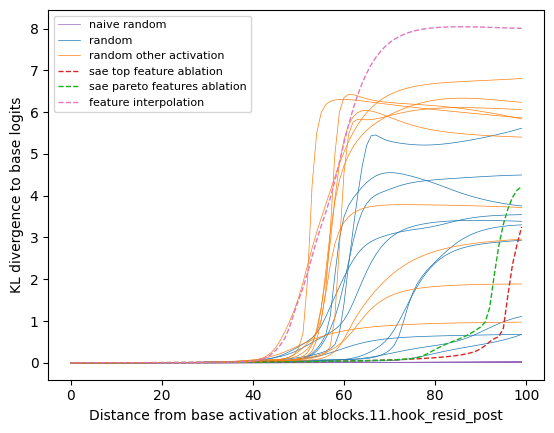

In [57]:
plot_results(results, cfg.n_steps, scale)

## Analysing perturbation results

In [28]:
def compute_entropy(probs):
    return -torch.sum(probs * torch.log(probs + 1e-10))

In [29]:
def analyze_feature_activation_dynamics(
    sae, cfg, base_ref, perturbations, act_thresh=0.1
):
    results = []
    for name, perturbation in perturbations.items():
        result = []
        activations = base_ref.act
        n_steps = cfg.n_steps
        direction = perturbation(activations)

        direction -= torch.mean(direction, dim=-1, keepdim=True)
        direction *= torch.linalg.vector_norm(
            activations, dim=-1, keepdim=True
        ) / torch.linalg.vector_norm(direction, dim=-1, keepdim=True)

        base_features = sae.encode(base_ref.act)
        max_act = 1  # base_features.squeeze().max().item()
        previous_active_features = set()

        perturbed_steps = []

        for step, alpha in enumerate(torch.linspace(*cfg.perturbation_range, n_steps)):
            perturbed_activations = activations + alpha * direction
            perturbed_features = sae.encode(perturbed_activations)
            current_active_features = set(
                (perturbed_features.squeeze() > (max_act * act_thresh))
                .nonzero()
                .squeeze(-1)
                .tolist()
            )
            new_active_features = current_active_features - previous_active_features
            deactivated_features = previous_active_features - current_active_features
            previous_active_features = current_active_features
            perturbed_steps.append(perturbed_activations)
            mean_feat_act = (
                perturbed_features[
                    ..., (perturbed_features.squeeze() > (max_act * act_thresh))
                ]
                .squeeze()
                .mean()
                .item()
            )
            feature_l2_norm = perturbed_features.norm(p=2).item()

            # mi_scores = mutual_info_regression(np.array(perturbed_activations), np.array(perturbed_outputs))

            result.append(
                {
                    "perturbation": name,
                    "alpha": alpha.item(),
                    "step": step + 1,
                    "current_active_count": len(current_active_features),
                    "new_active_count": len(new_active_features),
                    "deactivated_count": len(deactivated_features),
                    "new_active_features": list(new_active_features),
                    "deactivated_features": list(deactivated_features),
                    "mean_feat_act": mean_feat_act,
                    "feature_l2_norm": feature_l2_norm,
                }
            )

        logits_pert, cache = run_perturbed_activation(
            base_ref, torch.cat(perturbed_steps, dim=0)
        )
        kl_divs = compute_kl_div(base_ref.logits, logits_pert)[
            :, base_ref.perturbation_pos
        ].squeeze(-1)

        for i, kl_div in enumerate(kl_divs):
            entropy = compute_entropy(torch.softmax(logits_pert[i, -1, :], dim=-1))
            result[i]["kl_div"] = kl_div.item()
            result[i]["entropy"] = entropy.item()

        results.extend(result)

    return pd.DataFrame(results)

In [30]:
df = analyze_feature_activation_dynamics(
    sae, cfg, base_ref, perturbations, act_thresh=0.0
)

print(df.shape)
df.sample(5)

(300, 12)


,perturbation,alpha,step,current_active_count,new_active_count,deactivated_count,new_active_features,deactivated_features,mean_feat_act,feature_l2_norm,kl_div,entropy
27,naive random,0.272727,28,504,63,0,"[6018, 16779, 3213, 18704, 9468, 21398, 6039, ...",[],0.563676,26.954296,0.002176,6.945296
136,random,0.363636,37,13,1,1,[24149],[344],1.163630,5.774923,0.066918,6.810254
213,random other activation,0.131313,14,12,0,0,[],[],2.013334,15.033669,0.003519,6.882482
184,random,0.848485,85,23,0,0,[],[],1.352878,10.536449,4.590400,6.061071
93,naive random,0.939394,94,6172,72,0,"[8322, 22660, 1157, 4229, 4485, 4999, 8838, 13...",[],2.271988,245.214249,0.215480,7.239519


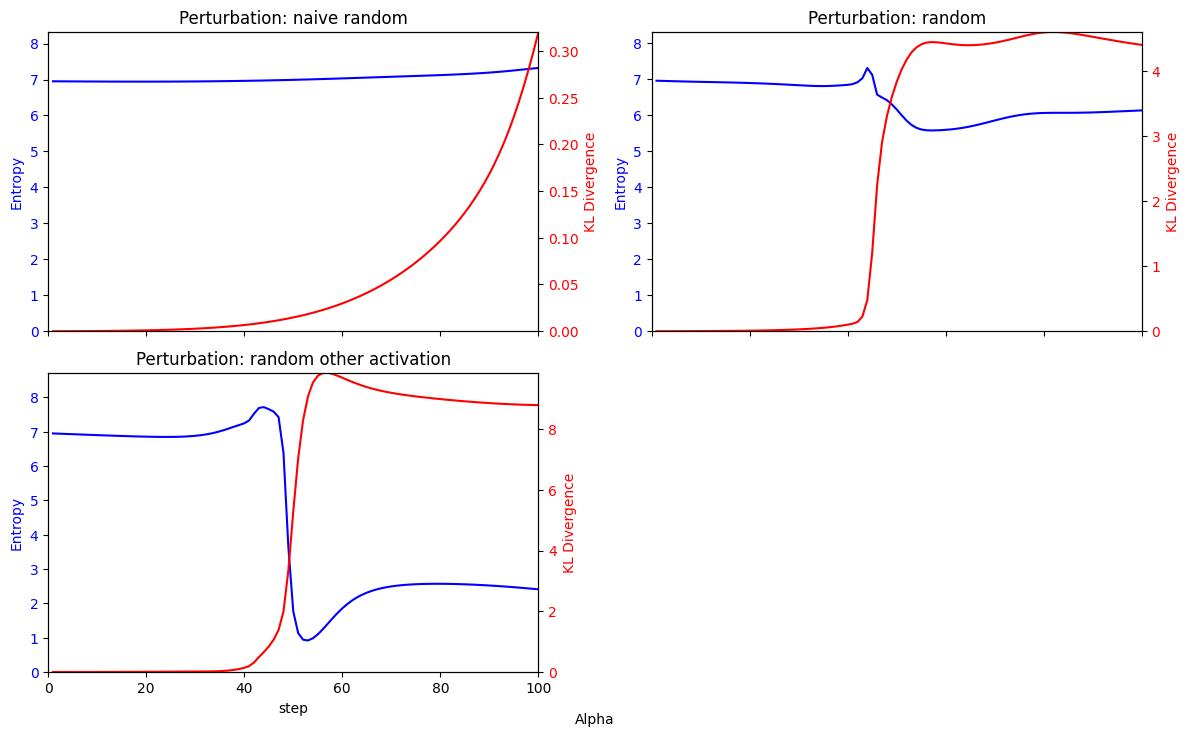

In [31]:
# Calculate grid dimensions
n_plots = len(perturbations)
n_cols = min(2, n_plots)  # Maximum 3 columns
n_rows = math.ceil(n_plots / n_cols)

# Set up the plot
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True, sharey=False
)
# fig.suptitle("Entropy and KL Divergence by Perturbation", fontsize=16)

# Flatten axes array for easier indexing
axes = axes.flatten() if n_plots > 1 else [axes]

# Create a plot for each perturbation
for i, perturbation in enumerate(perturbations):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    # Filter data for this perturbation
    perturb_data = df[df["perturbation"] == perturbation]

    # # Plot current_active_count
    # sns.lineplot(x='step', y='current_active_count', data=perturb_data, ax=ax1, color='blue', label='Number of Active Features')
    # ax1.set_ylabel('Number of Active Features', color='blue')
    # ax1.tick_params(axis='y', labelcolor='blue')
    # ax1.set_ylim(0, max(perturb_data['current_active_count']))

    # sns.lineplot(x='alpha', y='mean_feat_act', data=perturb_data, ax=ax1, color='blue', label='Mean Feat Act')
    # ax1.set_ylabel('Mean Feat Act', color='blue')
    # ax1.tick_params(axis='y', labelcolor='blue')
    # ax1.set_ylim(0, max(perturb_data['mean_feat_act']))

    # sns.lineplot(x='alpha', y='feature_l2_norm', data=perturb_data, ax=ax1, color='blue', label='Features L2 Norm')
    # ax1.set_ylabel('Features L2 Norm', color='blue')
    # ax1.tick_params(axis='y', labelcolor='blue')
    # ax1.set_ylim(0, max(perturb_data['feature_l2_norm']))

    sns.lineplot(
        x="step", y="entropy", data=perturb_data, ax=ax1, color="blue", label="Entropy"
    )
    ax1.set_ylabel("Entropy", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.set_ylim(0, max(perturb_data["entropy"]) + 1)

    # Plot kl_div
    sns.lineplot(
        x="step",
        y="kl_div",
        data=perturb_data,
        ax=ax2,
        color="red",
        label="KL Divergence",
    )
    ax2.set_ylabel("KL Divergence", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.set_ylim(0, max(perturb_data["kl_div"]))

    # Set title for this subplot
    ax1.set_title(f"Perturbation: {perturbation}")

    # Set x and y axes to start at 0
    ax1.set_xlim(0, max(perturb_data["step"]))

    # Remove legends
    ax1.get_legend().remove()
    ax2.get_legend().remove()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a common x-label
fig.text(0.5, 0.04, "Alpha", ha="center", va="center")

# Adjust layout and display the plot
plt.tight_layout()
plt.subplots_adjust(top=0.90, bottom=0.1)  # Adjust to prevent title overlap
plt.show()

## Frequency domain analysis 

In [32]:
name, perturbation = "random other activation", perturbations["random other activation"]
activations = base_ref.act
n_steps = cfg.n_steps
direction = perturbation(activations)
act_thresh = 0

direction -= torch.mean(direction, dim=-1, keepdim=True)
direction *= torch.linalg.vector_norm(
    activations, dim=-1, keepdim=True
) / torch.linalg.vector_norm(direction, dim=-1, keepdim=True)

# base_features = sae.encode(base_ref.act)
max_act = 1  # base_features.squeeze().max().item()
previous_active_features = set()

perturbed_steps = []

for alpha in torch.linspace(*cfg.perturbation_range, n_steps):
    perturbed_activations = activations + alpha * direction
    perturbed_features = sae.encode(perturbed_activations)
    current_active_features = set(
        (perturbed_features.squeeze().abs() > (max_act * act_thresh))
        .nonzero()
        .squeeze(-1)
        .tolist()
    )
    new_active_features = current_active_features - previous_active_features
    deactivated_features = previous_active_features - current_active_features
    previous_active_features = current_active_features
    perturbed_steps.append(perturbed_activations)
    mean_feat_act = (
        perturbed_features[
            ..., (perturbed_features.squeeze().abs() > (max_act * act_thresh))
        ]
        .squeeze()
        .mean()
        .item(),
    )
    feature_l2_norm = perturbed_features.norm(p=2).item()

logits_pert, cache = run_perturbed_activation(
    base_ref, torch.cat(perturbed_steps, dim=0)
)

kl_divs = compute_kl_div(base_ref.logits, logits_pert)[
    :, base_ref.perturbation_pos
].squeeze(-1)

perturbed_steps = torch.cat(perturbed_steps, dim=0).squeeze(dim=1)
activations = activations.squeeze()

In [167]:
from scipy.stats import spearmanr
import warnings


def compare_power_spectra(base_activations, perturbed_activations, kl_divs):
    base_spectrum = np.abs(np.fft.fft(base_activations)) ** 2
    perturbed_spectra = [np.abs(np.fft.fft(act)) ** 2 for act in perturbed_activations]

    changes = [np.sum(np.abs(ps - base_spectrum)) for ps in perturbed_spectra]

    plt.figure(figsize=(10, 6))
    plt.scatter(changes, kl_divs)
    plt.xlabel("Change in Power Spectrum")
    plt.ylabel("KL Divergence")
    plt.title("KL Divergence vs Change in Power Spectrum")
    plt.show()

    correlation = np.corrcoef(changes, kl_divs)[0, 1]
    print(f"Correlation between spectral change and KL divergence: {correlation}")


def analyze_frequency_bands(
    base_activations, perturbed_activations, kl_divs, n_bands=20
):
    base_spectrum = np.abs(np.fft.fft(base_activations)) ** 2
    perturbed_spectra = [np.abs(np.fft.fft(act)) ** 2 for act in perturbed_activations]

    band_size = len(base_spectrum) // n_bands
    band_changes = []

    for i in range(n_bands):
        start = i * band_size
        end = (i + 1) * band_size
        band_changes.append(
            [
                np.sum(np.abs(ps[start:end] - base_spectrum[start:end]))
                for ps in perturbed_spectra
            ]
        )

    correlations = [np.corrcoef(changes, kl_divs)[0, 1] for changes in band_changes]

    plt.figure(figsize=(10, 6))
    plt.bar(range(n_bands), correlations)
    plt.xlabel("Frequency Band")
    plt.ylabel("Correlation with KL Divergence")
    plt.title("Correlation of Frequency Band Changes with KL Divergence")
    plt.show()


def visualize_spectrum_changes(base_activations, perturbed_activations, alphas):
    base_spectrum = np.abs(np.fft.fft(base_activations)) ** 2
    perturbed_spectra = [np.abs(np.fft.fft(act)) ** 2 for act in perturbed_activations]

    plt.figure(figsize=(12, 8))

    for i, (ps, alpha) in enumerate(zip(perturbed_spectra, alphas)):
        plt.plot(ps - base_spectrum, label=f"α={alpha:.2f}" if i % 50 == 0 else "")

    plt.xlabel("Frequency")
    plt.ylabel("Change in Power")
    plt.title("Changes in Power Spectrum with Perturbation")
    plt.legend()
    plt.show()


def analyze_individual_frequencies(base_activations, perturbed_activations, kl_divs):
    base_spectrum = np.abs(np.fft.fft(base_activations)) ** 2
    perturbed_spectra = [np.abs(np.fft.fft(act)) ** 2 for act in perturbed_activations]

    frequency_correlations = []
    for i in range(len(base_spectrum)):
        changes = [ps[i] - base_spectrum[i] for ps in perturbed_spectra]
        correlation = np.corrcoef(changes, kl_divs)[0, 1]
        frequency_correlations.append(correlation)

    plt.figure(figsize=(12, 6))
    plt.plot(frequency_correlations)
    plt.xlabel("Frequency")
    plt.ylabel("Correlation with KL Divergence")
    plt.title("Correlation of Individual Frequency Changes with KL Divergence")
    plt.show()


def analyze_frequency_thresholds(
    base_activations, perturbed_activations, kl_divs, threshold=1.0
):
    base_spectrum = np.abs(np.fft.fft(base_activations)) ** 2
    perturbed_spectra = [np.abs(np.fft.fft(act)) ** 2 for act in perturbed_activations]

    frequency_thresholds = []
    for i in range(len(base_spectrum)):
        changes = [ps[i] - base_spectrum[i] for ps in perturbed_spectra]
        threshold_idx = next(
            (idx for idx, kl in enumerate(kl_divs) if kl > threshold), len(kl_divs)
        )
        frequency_thresholds.append(
            changes[threshold_idx] if threshold_idx < len(changes) else np.inf
        )

    plt.figure(figsize=(12, 6))
    plt.plot(frequency_thresholds)
    plt.xlabel("Frequency")
    plt.ylabel("Perturbation Magnitude at Threshold")
    plt.title(f"Perturbation Magnitude Required to Reach KL Divergence of {threshold}")
    plt.show()


def analyze_frequency_sae_relationship(
    base_activation, perturbed_activations, sae, top_k=100
):
    base_spectrum = np.abs(np.fft.fft(base_activation)) ** 2
    perturbed_spectra = [np.abs(np.fft.fft(act)) ** 2 for act in perturbed_activations]

    frequency_changes = np.array([ps - base_spectrum for ps in perturbed_spectra])

    # Encode the base activation to get SAE features
    sae_features = sae.encode(base_activation.unsqueeze(0)).detach().numpy().squeeze()

    # Select top K features based on activation magnitude
    top_features_idx = np.argsort(np.abs(sae_features))[-top_k:]
    top_features = sae_features[top_features_idx]

    correlations = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for feature_activation in top_features:
            corr = [
                (
                    spearmanr(
                        frequency_changes[:, j],
                        np.full(len(frequency_changes), feature_activation),
                    )[0]
                    if not np.all(frequency_changes[:, j] == frequency_changes[0, j])
                    else 0
                )
                for j in range(frequency_changes.shape[1])
            ]
            correlations.append(corr)

    correlations = np.array(correlations)

    plt.figure(figsize=(12, 8))
    plt.imshow(correlations, aspect="auto", cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(label="Correlation")
    plt.xlabel("Frequency")
    plt.ylabel(f"Top {top_k} SAE Features")
    plt.title("Correlation between Frequency Changes and Top SAE Feature Activations")
    plt.show()

    # Additional analysis: Top correlated frequencies for each feature
    top_correlated_freqs = []
    for i, corr in enumerate(correlations):
        valid_corr = corr[~np.isnan(corr)]
        if len(valid_corr) > 0:
            top_freqs = np.argsort(np.abs(valid_corr))[
                -5:
            ]  # Top 5 correlated frequencies
            top_correlated_freqs.append(
                (top_features_idx[i], top_freqs, [valid_corr[j] for j in top_freqs])
            )

    print(f"Top correlated frequencies for each of the top {top_k} SAE features:")
    for feature, freqs, corrs in top_correlated_freqs[
        :10
    ]:  # Print only first 10 for brevity
        print(f"Feature {feature}:")
        for freq, corr in zip(freqs, corrs):
            print(f"  Frequency {freq}: correlation {corr:.3f}")
        print()

    # Print statistics about constant frequency changes
    constant_freq_changes = np.sum(
        [
            np.all(frequency_changes[:, j] == frequency_changes[0, j])
            for j in range(frequency_changes.shape[1])
        ]
    )

    print(f"Number of constant frequency changes: {constant_freq_changes}")

In [40]:
# compare_power_spectra(activations, perturbed_steps, kl_divs)

In [182]:
from scipy.fft import fft


def sae_power_spectrum_analysis(sae, base_activation, perturbed_activations, kl_divs):
    # Reconstruct activations using SAE
    base_features = sae.encode(base_activation.unsqueeze(0))
    base_reconstructed = sae.decode(base_features).detach().numpy().squeeze()

    perturbed_features = sae.encode(perturbed_activations)
    perturbed_reconstructed = sae.decode(perturbed_features).detach().numpy()

    # Compute power spectra
    base_spectrum = np.abs(fft(base_reconstructed)) ** 2
    perturbed_spectra = np.abs(fft(perturbed_reconstructed, axis=1)) ** 2

    # Compute changes in power spectrum
    spectrum_changes = np.sum(np.abs(perturbed_spectra - base_spectrum), axis=1)

    # Plot KL divergence vs change in power spectrum
    plt.figure(figsize=(10, 6))
    plt.scatter(spectrum_changes, kl_divs)
    plt.xlabel("Change in SAE-based Power Spectrum")
    plt.ylabel("KL Divergence")
    plt.title("KL Divergence vs Change in SAE-based Power Spectrum")
    plt.show()

    # Analyze which SAE features contribute most to changes
    feature_contributions = np.abs(perturbed_features - base_features).mean(dim=0)
    top_features = np.argsort(feature_contributions)[
        -10:
    ]  # Top 10 contributing features

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_contributions)), feature_contributions)
    plt.xlabel("SAE Feature Index")
    plt.ylabel("Average Contribution to Change")
    plt.title("SAE Feature Contributions to Activation Changes")
    plt.yscale("log")
    plt.show()

    print("Top contributing SAE features:")
    for i, feature in enumerate(reversed(top_features)):
        print(f"{i+1}. Feature {feature}: {feature_contributions[feature]:.4f}")

    return spectrum_changes, feature_contributions

In [41]:
# spectrum_changes, feature_contributions = sae_power_spectrum_analysis(sae, activations, perturbed_steps, kl_divs)

In [45]:
# analyze_frequency_bands(activations, perturbed_steps, kl_divs, n_bands=50)

In [42]:
# alphas = np.linspace(*cfg.perturbation_range, cfg.n_steps)
# visualize_spectrum_changes(activations, perturbed_steps, alphas)

In [43]:
# analyze_individual_frequencies(activations, perturbed_steps, kl_divs)

In [44]:
# analyze_frequency_thresholds(activations, perturbed_steps, kl_divs, threshold=1.0)

In [ ]:
# analyze_frequency_sae_relationship(activations, perturbed_steps, sae)

In [46]:
# n_bands = 10
# base_activation = activations
# base_output = logits_pert[:, -1, :].to(device)

# fft_activation = np.fft.fft(base_activation)
# band_size = len(fft_activation) // n_bands

# kl_divs = []

# for i in range(n_bands):
#     perturbed_fft = fft_activation.copy()
#     start = i * band_size
#     end = (i + 1) * band_size
#     perturbed_fft[start:end] *= 2  # Double the magnitude of this band

#     perturbed_activation_fft = np.fft.ifft(perturbed_fft).real
#     perturbed_activations_fft = (
#         torch.tensor(perturbed_activation_fft).unsqueeze(dim=0).unsqueeze(dim=0)
#     )

#     def hook(act, hook):
#         act[:, base_ref.perturbation_pos, :] = perturbed_activations_fft

#     with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
#         prompts = torch.cat(
#             [base_ref.prompt for _ in range(len(perturbed_activations_fft))]
#         )
#         logits_pert_fft, _ = base_ref.model.run_with_cache(prompts)

#     perturbed_output = logits_pert_fft[:, -1, :]

#     kl_div = F.kl_div(
#         F.log_softmax(perturbed_output, dim=-1),
#         F.softmax(base_output, dim=-1),
#         reduction="batchmean",
#     )
#     kl_divs.append(kl_div.item())

# plt.figure(figsize=(10, 6))
# plt.bar(range(n_bands), kl_divs)
# plt.xlabel("Frequency Band")
# plt.ylabel("KL Divergence")
# plt.title("Impact of Frequency Band Perturbation on Model Output")
# plt.show()

In [47]:
# n_steps = 100
# base_activation = activations
# base_output = logits_pert[:, -1, :].to(device)

# fft_activation = np.fft.fft(base_activation)

# kl_divs = []

# for i in range(n_steps):
#     cutoff = int(len(fft_activation) * (1 - i / n_steps))
#     filtered_fft = fft_activation.copy()
#     filtered_fft[cutoff:] = 0

#     filtered_activation = np.fft.ifft(filtered_fft).real
#     filtered_activations = (
#         torch.tensor(filtered_activation).unsqueeze(dim=0).unsqueeze(dim=0)
#     )

#     def hook(act, hook):
#         act[:, base_ref.perturbation_pos, :] = filtered_activations

#     with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
#         prompts = torch.cat([base_ref.prompt for _ in range(len(filtered_activations))])
#         logits_pert_fft, _ = base_ref.model.run_with_cache(prompts)

#     filtered_output = logits_pert_fft[:, -1, :]

#     kl_div = F.kl_div(
#         F.log_softmax(filtered_output, dim=-1),
#         F.softmax(base_output, dim=-1),
#         reduction="batchmean",
#     )
#     kl_divs.append(kl_div.item())

# plt.figure(figsize=(10, 6))
# plt.plot(np.linspace(0, 1, n_steps), kl_divs)
# plt.xlabel("Fraction of High Frequencies Removed")
# plt.ylabel("KL Divergence")
# plt.title("Impact of High Frequency Removal on Model Output")
# plt.show()

## Visualising perturbations

In [33]:
name = "random other activation"
perturbation = perturbations[name]
activations = base_ref.act
n_steps = cfg.n_steps
direction = perturbation(activations)
act_thresh = 0

direction -= torch.mean(direction, dim=-1, keepdim=True)
direction *= torch.linalg.vector_norm(
    activations, dim=-1, keepdim=True
) / torch.linalg.vector_norm(direction, dim=-1, keepdim=True)

# base_features = sae.encode(base_ref.act)
max_act = 1  # base_features.squeeze().max().item()
previous_active_features = set()

perturbed_steps = []

for alpha in torch.linspace(*cfg.perturbation_range, n_steps):
    perturbed_activations = activations + alpha * direction
    perturbed_features = sae.encode(perturbed_activations)
    current_active_features = set(
        (perturbed_features.squeeze().abs() > (max_act * act_thresh))
        .nonzero()
        .squeeze(-1)
        .tolist()
    )
    new_active_features = current_active_features - previous_active_features
    deactivated_features = previous_active_features - current_active_features
    previous_active_features = current_active_features
    perturbed_steps.append(perturbed_activations)
    mean_feat_act = (
        perturbed_features[
            ..., (perturbed_features.squeeze().abs() > (max_act * act_thresh))
        ]
        .squeeze()
        .mean()
        .item(),
    )
    feature_l2_norm = perturbed_features.norm(p=2).item()

logits_pert, cache = run_perturbed_activation(
    base_ref, torch.cat(perturbed_steps, dim=0)
)

kl_divs = compute_kl_div(base_ref.logits, logits_pert)[
    :, base_ref.perturbation_pos
].squeeze(-1)

perturbed_steps = torch.cat(perturbed_steps, dim=0).squeeze(dim=1)
activations = activations.squeeze()

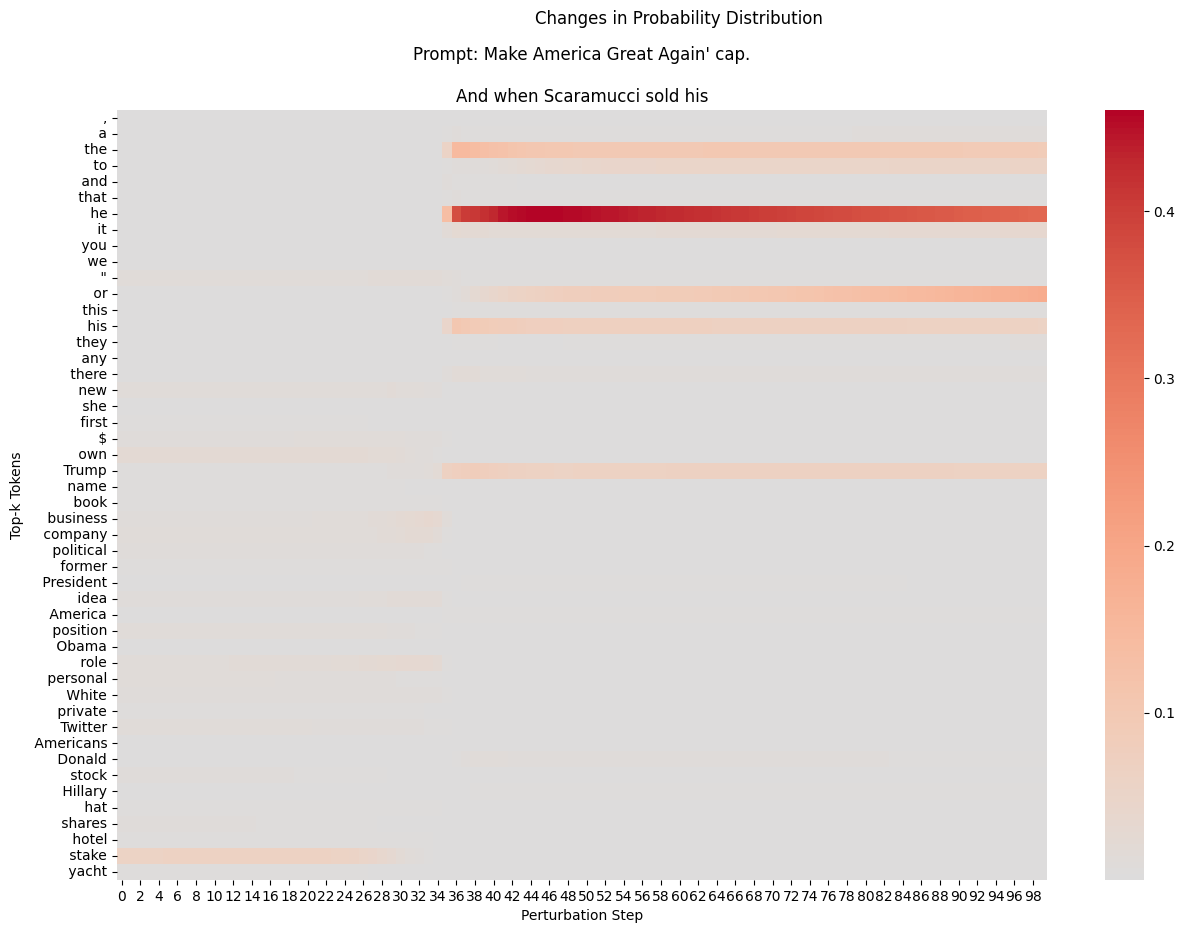

In [34]:
top_k = 25
base_output = logits_pert[0, -1, :]
base_probs = torch.softmax(base_output, dim=-1)
_, base_top_k_indices = torch.topk(base_probs, top_k)

perturb_probs = torch.softmax(logits_pert[:, -1, :], dim=-1)
_, perturb_top_k_indices = torch.topk(perturb_probs[-1, :], top_k)

top_k_indices = torch.cat([base_top_k_indices, perturb_top_k_indices]).unique()
prob_changes = perturb_probs[:, top_k_indices].T.cpu().numpy()

plt.figure(figsize=(15, 10))

labels = model.tokenizer.batch_decode(top_k_indices)
sns.heatmap(prob_changes, cmap="coolwarm", center=0, yticklabels=labels)

plt.ylabel("Top-k Tokens")
plt.xlabel("Perturbation Step")
plt.suptitle("Changes in Probability Distribution")

base_prompt = model.tokenizer.decode(base_ref.prompt[0])
# plt.title(f"Prompt: {base_prompt} --> {controlled_other_prompt}")
plt.title(f"Prompt: {base_prompt}")
plt.show()

In [182]:
# plt.figure(figsize=(12, 8))
# sns.heatmap(perturbed_steps, cmap="coolwarm", center=0)
# plt.xlabel("Activation Dimension")
# plt.ylabel("Perturbation Steps")
# plt.title("Changes in Residual Stream Activations")
# plt.show()

In [124]:
# data = perturbed_steps.squeeze(1)
# data = data[::5]
# data.shape

In [125]:
# import matplotlib.cm as cm
# import matplotlib.colors as mcolors
# import joypy

# # Convert the tensor into a DataFrame suitable for plotting
# df = pd.DataFrame(data)
# steps = data.shape[0]
# df["Step"] = np.arange(0, steps * 5, 5)

# # Melt the DataFrame for Joypy
# melted_data = df.melt(id_vars="Step", var_name="Feature", value_name="Activation")

# # Plotting with Joypy
# fig, ax = plt.subplots(figsize=(15, 10))

# joypy.joyplot(
#     data=melted_data,
#     by="Step",
#     column="Activation",
#     figsize=(15, 10),
#     title="Ridgeline Plot of Residual Stream Activations over Steps",
#     grid=True,
#     overlap=1,  # Reduce overlap
#     colormap=plt.cm.viridis,
#     ax=ax,
# )

# # Customize the y-axis
# steps_to_show = np.arange(0, steps * 5, 5)  # Show every 10th step
# ax.set_yticks(steps_to_show)  # Set the y-ticks
# ax.set_yticklabels(steps_to_show)  # Set the y-tick labels

# # Add color bar
# norm = mcolors.Normalize(
#     vmin=melted_data["Activation"].min(), vmax=melted_data["Activation"].max()
# )
# sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
# sm.set_array([])  # Only needed for matplotlib < 3.1

# # # Create a smaller colorbar
# # cbar = fig.colorbar(sm, ax=ax, shrink=0.5, aspect=10, pad=0.02)
# # cbar.set_label('Activation Intensity')

# plt.xlabel("Activation")
# plt.ylabel("Step")
# # plt.tight_layout()  # Adjust layout to make space for the labels
# plt.show()

## Feature contributions

### Ablating features in order

In [35]:
def ablate_feature(model, base_ref, sae, feature_to_ablate):
    # Get the base activation from the residual stream
    base_act = base_ref.act.squeeze()

    # Encode the activation into SAE feature space
    feature_acts = sae.encode(base_act)

    # Ablate the specified feature
    feature_acts[feature_to_ablate] = 0

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    # Run the model with the perturbed activation
    def hook(act, hook):
        act[:, -1, :] = perturbed_act

    with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
        logits_pert, _ = model.run_with_cache(base_ref.prompt)

    return logits_pert


# Get base logits
base_act = base_ref.act.squeeze()
logits_base, _ = model.run_with_cache(base_ref.prompt)
logprobs_base = F.log_softmax(logits_base[:, -1, :], dim=-1)

feature_acts = sae.encode(base_act)
active_feature_ids = (feature_acts > 0.0).nonzero().squeeze().tolist()

# Ablate each feature and compute KL divergence
data = []

for feature_id in active_feature_ids:
    logits_pert = ablate_feature(model, base_ref, sae, feature_id)
    logprobs_pert = F.log_softmax(logits_pert[:, -1, :], dim=-1)
    kl_div = F.kl_div(
        logprobs_pert, logprobs_base, log_target=True, reduction="batchmean"
    )

    # Get the original activation of this feature
    original_act = feature_acts[feature_id].item()
    data.append(
        {"feature_id": feature_id, "kl_div": kl_div.item(), "feature_act": original_act}
    )

df = pd.DataFrame(data)

In [36]:
df.sort_values(by="kl_div", ascending=False).head(5)

,feature_id,kl_div,feature_act
12,15900,3.253532,20.546534
9,12896,0.003106,3.726257
8,11114,0.000771,1.745580
13,19223,0.000661,2.140544
15,22119,0.000597,1.232947


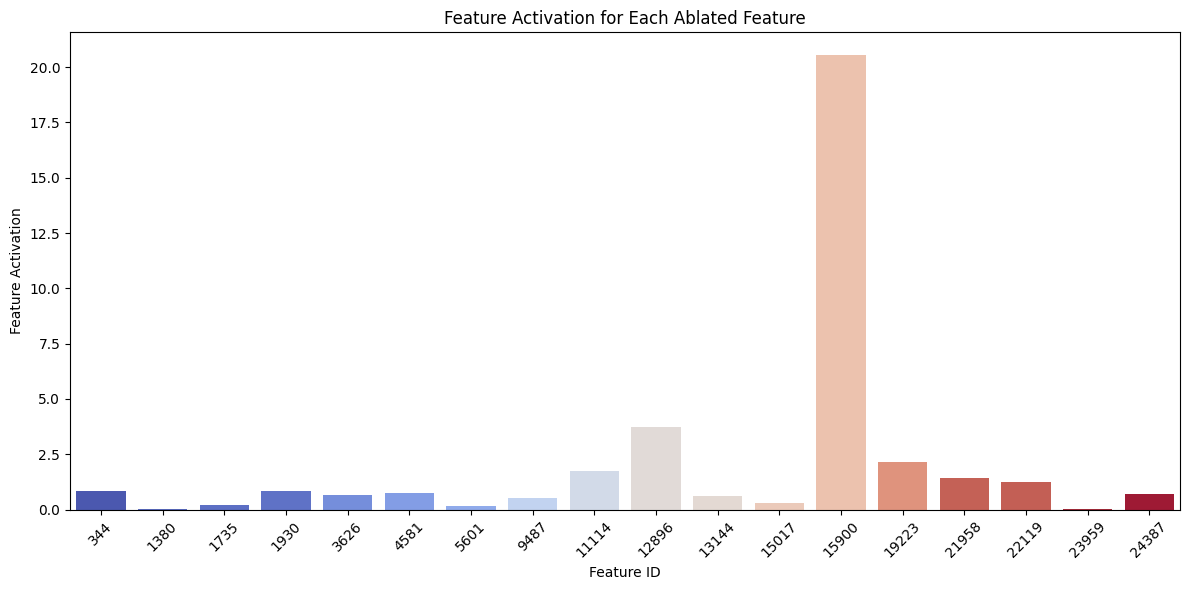

In [37]:
df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
# sns.barplot(x='feature_id', y='kl_div', data=df, palette='coolwarm', hue='feature_id', legend=False)
sns.barplot(
    x="feature_id",
    y="feature_act",
    data=df,
    palette="coolwarm",
    hue="feature_id",
    legend=False,
)

plt.xlabel("Feature ID")
plt.ylabel("Feature Activation")
plt.title("Feature Activation for Each Ablated Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [176]:
# def generate_sae_feature_ablation_perturbation(base_ref, sae, n_steps):
#     feature_acts = sae.encode(base_ref.act.squeeze())
#     active_feature_ids = (feature_acts > 0).nonzero().squeeze()
#     sorted_indices = torch.argsort(feature_acts[non_negative_features], descending=True)
#     sorted_active_feature_ids = active_feature_ids[sorted_indices]

#     logits_base, _ = base_ref.model.run_with_cache(base_ref.prompt)
#     logprobs_base = F.log_softmax(logits_base[:, -1, :], dim=-1)

#     kl_divs = [0.0]

#     for f_id in sorted_active_feature_ids:
#         feature_acts[f_id] = 0
#         perturbed_act = sae.decode(feature_acts)

#         def hook(act, hook):
#             act[:, -1, :] = perturbed_act

#         with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
#             logits_pert, _ = model.run_with_cache(base_ref.prompt)

#         logprobs_pert = F.log_softmax(logits_pert[:, -1, :], dim=-1)
#         kl_div = F.kl_div(logprobs_pert, logprobs_base, log_target=True, reduction="batchmean")
#         kl_divs.append(kl_div.item())

#     kl_divs.extend([kl_div] * (n_steps - len(sorted_active_feature_ids)))
#     return torch.tensor(kl_divs)

# sae_feature_ablation_results = generate_sae_feature_ablation_perturbation(base_ref, sae, 200)
# results['sae feature ablations'] = [sae_feature_ablation_results]
# plot_results(results)

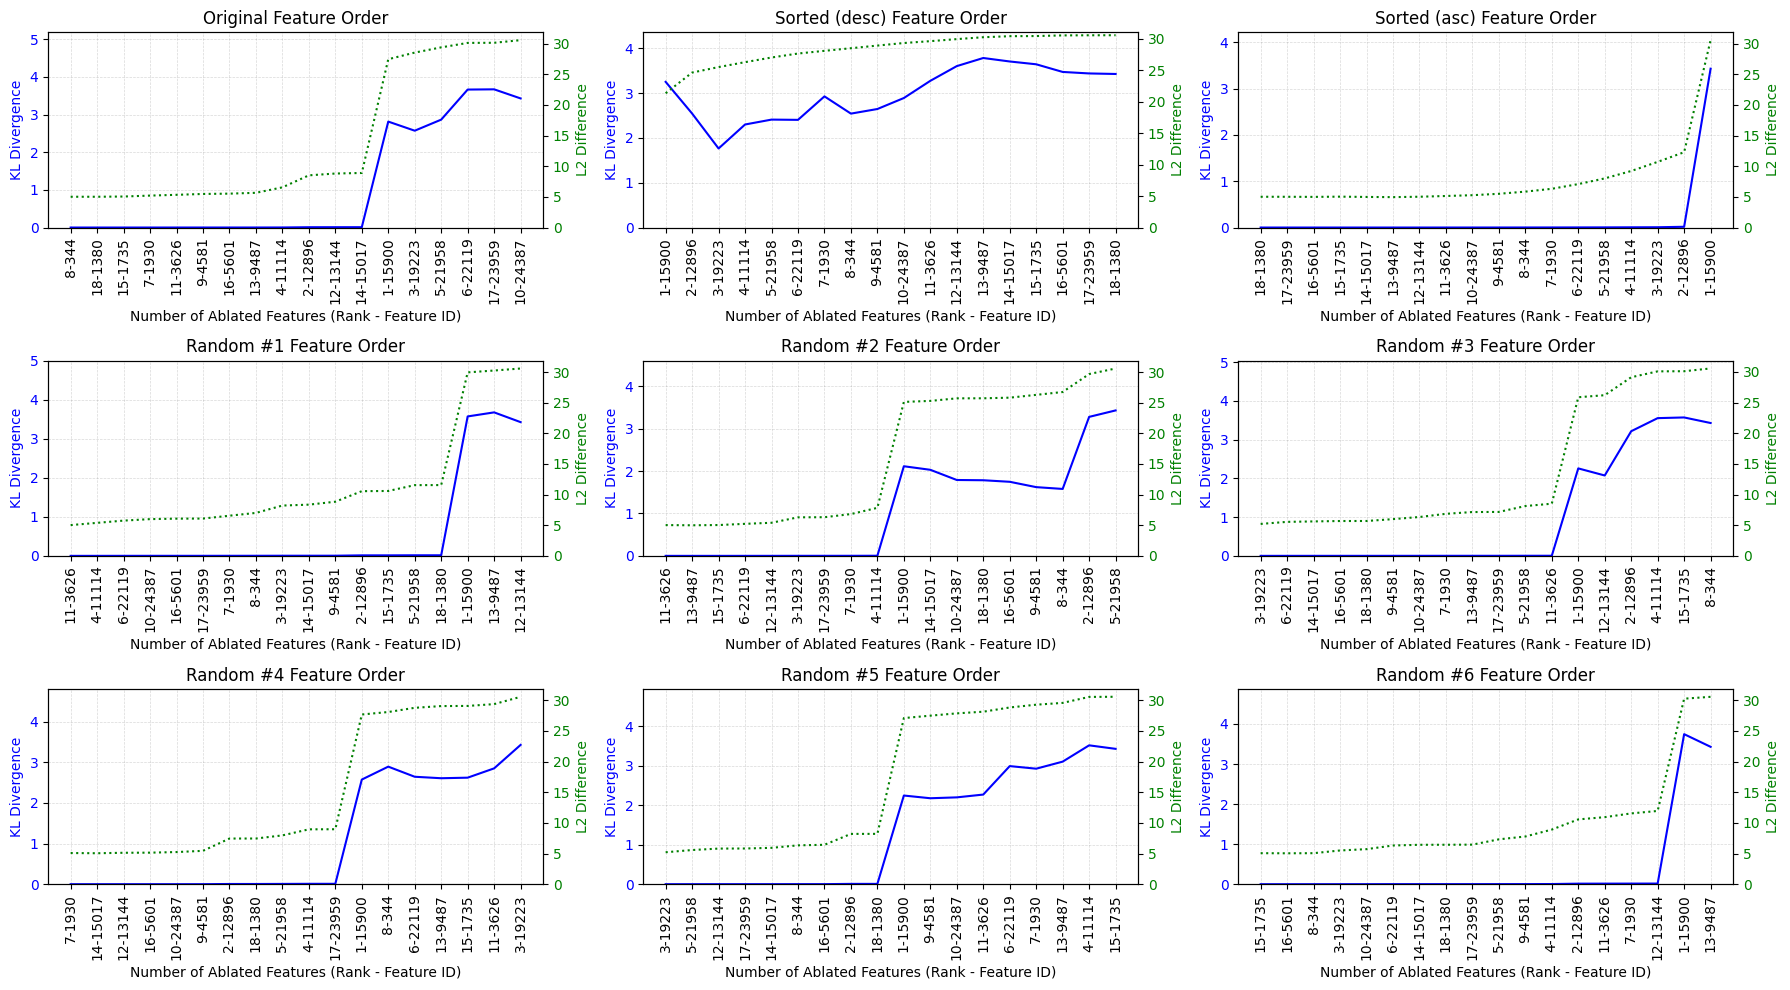

In [38]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple


def perturb_residual_stream(
    model, base_ref, sae, feature_order: List[int]
) -> Tuple[List[float], List[float]]:
    base_act = base_ref.act.squeeze()
    original_feature_acts = sae.encode(base_act)

    kl_divs = []
    l2_diffs = []

    # Get base logits
    logits_base, _ = model.run_with_cache(base_ref.prompt)
    logprobs_base = F.log_softmax(logits_base[:, -1, :], dim=-1)

    ablated_feature_ids = []

    for step in range(len(feature_order)):
        feature_to_ablate = feature_order[step]
        ablated_feature_ids.append(feature_to_ablate)

        feature_acts = original_feature_acts.clone()
        feature_acts[ablated_feature_ids] = 0  # Ablate all features up to this step
        perturbed_act = sae.decode(feature_acts)

        # TODO: move to read layer (11)
        l2_diff = torch.norm(base_act - perturbed_act)
        l2_diffs.append(l2_diff.item())

        def hook(act, hook):
            act[:, -1, :] = perturbed_act

        with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
            logits_pert, _ = model.run_with_cache(base_ref.prompt)

        logprobs_pert = F.log_softmax(logits_pert[:, -1, :], dim=-1)
        kl_div = F.kl_div(
            logprobs_pert, logprobs_base, log_target=True, reduction="batchmean"
        )
        kl_divs.append(kl_div.item())

    return kl_divs, l2_diffs


def plot_ablation_results(model, base_ref, sae, num_sorts=4):
    base_act = base_ref.act.squeeze()
    original_feature_acts = sae.encode(base_act)

    non_negative_features = (original_feature_acts > 0).nonzero().squeeze()
    if isinstance(non_negative_features, int):
        non_negative_features = torch.tensor([non_negative_features])

    # Create different sortings
    sortings = []
    labels = []

    # 1. Original order
    sortings.append(non_negative_features.tolist())
    labels.append("Original")

    # 2. Sorted by activation (descending)
    desc_sorted_indices = torch.argsort(
        original_feature_acts[non_negative_features], descending=True
    )
    sortings.append(non_negative_features[desc_sorted_indices].tolist())
    labels.append("Sorted (desc)")

    # 3. Reverse sorted
    sortings.append(non_negative_features[desc_sorted_indices.flip(0)].tolist())
    labels.append("Sorted (asc)")

    # Random #1-6
    for i in range(6):
        sortings.append(
            non_negative_features[torch.randperm(len(non_negative_features))].tolist()
        )
        labels.append(f"Random #{i+1}")

    # Plot setup
    fig, axs = plt.subplots(3, 3, figsize=(18, 10))
    axs = axs.ravel()

    n_features = len(non_negative_features)
    ranks = {
        idx.item(): i + 1
        for i, idx in enumerate(non_negative_features[desc_sorted_indices])
    }

    for i, (sorting, label) in enumerate(zip(sortings, labels)):
        kl_divs, l2_diffs = perturb_residual_stream(model, base_ref, sae, sorting)

        ablated_feature_labels = [f"{ranks[f_id]}-{f_id}" for f_id in sorting]

        ax = axs[i]
        (line1,) = ax.plot(range(n_features), kl_divs, "b-", label="KL Divergence")
        ax.set_ylabel("KL Divergence", color="b")
        ax.tick_params(axis="y", labelcolor="b")
        ax.set_ylim(bottom=0, top=max(kl_divs) + np.std(kl_divs))
        ax.set_xticks(range(n_features))
        ax.set_xticklabels(ablated_feature_labels, rotation=90)
        ax.grid(True, color="gray", linestyle="--", linewidth=0.5, alpha=0.3)

        ax2 = ax.twinx()
        (line2,) = ax2.plot(range(n_features), l2_diffs, "g:", label="L2 Difference")
        ax2.set_ylabel("L2 Difference", color="green")
        ax2.tick_params(axis="y", labelcolor="green")
        ax2.set_ylim(bottom=0)

        ax.set_title(f"{label} Feature Order")
        ax.set_xlabel("Number of Ablated Features (Rank - Feature ID)")

        # Add legend
        lines = [line1, line2]
        # ax.legend(lines, [l.get_label() for l in lines], loc="upper left")

    plt.tight_layout()
    plt.show()


plot_ablation_results(model, base_ref, sae)

### Finding low rank sensitive features

In [39]:
from itertools import combinations


def generate_ablation_combinations(feature_ids):
    all_combinations = []
    for r in range(1, len(feature_ids) + 1):
        all_combinations.extend(combinations(feature_ids, r))
    return all_combinations


def generate_ablation_combinations_of_triplets(feature_ids):
    return list(combinations(feature_ids, 3))

In [41]:
base_act = base_ref.act.squeeze()
feature_acts = sae.encode(base_act)

print(base_act.norm())

non_negative_features = (feature_acts > 0).nonzero().squeeze()
if isinstance(non_negative_features, int):
    non_negative_features = torch.tensor([non_negative_features])

# Get base logits
logits_base, _ = model.run_with_cache(base_ref.prompt)
logprobs_base = F.log_softmax(logits_base[:, -1, :], dim=-1)

desc_sorted_indices = torch.argsort(
    feature_acts[non_negative_features], descending=True
)
sorted_feature_ids_desc = non_negative_features[desc_sorted_indices]

print(sorted_feature_ids_desc)
print([round(n, 4) for n in feature_acts[sorted_feature_ids_desc].numpy()])

tensor(53.8895)
tensor([15900, 12896, 19223, 11114, 21958, 22119,  1930,   344,  4581, 24387,
         3626, 13144,  9487, 15017,  1735,  5601, 23959,  1380])
[20.5465, 3.7263, 2.1405, 1.7456, 1.4152, 1.2329, 0.8531, 0.8422, 0.7475, 0.6967, 0.6509, 0.6259, 0.5186, 0.2785, 0.1977, 0.1666, 0.0336, 0.0128]


In [23]:
# plt.hist(F.softmax(feature_acts[sorted_feature_ids_desc], dim=-1))
# plt.show()

In [42]:
print(len(sorted_feature_ids_desc))

skip = 0
n_features = 9
feature_ids_to_ablate = [
    f_id.item() for f_id in sorted_feature_ids_desc[skip : skip + n_features]
]
print(feature_ids_to_ablate)
print(len(feature_ids_to_ablate), 2**n_features)

18
[15900, 12896, 19223, 11114, 21958, 22119, 1930, 344, 4581]
9 512


In [43]:
ablation_results = []

all_combinations = generate_ablation_combinations(feature_ids_to_ablate)
# all_combinations = generate_ablation_combinations_of_triplets(feature_ids_to_ablate)
l2_act = base_act.norm()

for i, feature_ids in enumerate(all_combinations):
    if i % 250 == 0:
        print(f"Step {i}/{len(all_combinations)}")

    step_feature_acts = feature_acts.clone()
    step_feature_acts[list(feature_ids)] = 0
    perturbed_act = sae.decode(step_feature_acts)

    def hook(act, hook):
        act[:, -1, :] = perturbed_act

    with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
        logits_pert, _ = model.run_with_cache(base_ref.prompt)

    logprobs_pert = F.log_softmax(logits_pert[:, -1, :], dim=-1)
    kl_div = F.kl_div(
        logprobs_pert, logprobs_base, log_target=True, reduction="batchmean"
    )
    l2_pert = torch.norm(base_act - perturbed_act)

    ablation_results.append(
        {
            "feature_ids": feature_ids,
            "n_features": len(feature_ids),
            "kl_div": kl_div.item(),
            "l2": l2_pert.item(),
            "L2(P) / L2(A)": l2_pert.item() / l2_act.item(),
            "perturbed_act": perturbed_act,
        }
    )

Step 0/511
Step 250/511
Step 500/511


In [44]:
abl_df = pd.DataFrame(ablation_results)
# comb_df.kl_div.describe()
# abl_df.head()

In [45]:
abl_df.sort_values(by="kl_div", ascending=False).head()

,feature_ids,n_features,kl_div,l2,L2(P) / L2(A),perturbed_act
12,"(15900, 21958)",2,4.214313,22.041143,0.409006,"[tensor(-0.0974), tensor(0.1143), tensor(-0.17..."
60,"(15900, 11114, 1930)",3,4.139725,22.490452,0.417344,"[tensor(-0.1510), tensor(0.1170), tensor(-0.06..."
13,"(15900, 22119)",2,4.135861,21.877678,0.405973,"[tensor(-0.1117), tensor(0.1227), tensor(-0.16..."
70,"(15900, 1930, 344)",3,4.115581,22.030329,0.408805,"[tensor(-0.0733), tensor(0.1328), tensor(-0.20..."
67,"(15900, 22119, 1930)",3,4.106128,22.243963,0.412770,"[tensor(-0.1172), tensor(0.1214), tensor(-0.20..."


In [49]:
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient


lp_values = abl_df["L2(P) / L2(A)"]  # Your L(P) values
kl_div_values = abl_df.kl_div  # Your KL divergence values
costs = np.column_stack((lp_values, -kl_div_values))
pareto_points = is_pareto_efficient(costs)

abl_df["is_pareto_efficient"] = pareto_points
abl_df["diff_from_max"] = abl_df.kl_div.apply(lambda kl: kl - abl_df.kl_div.max())
abl_df["ratio"] = abl_df.kl_div / abl_df["L2(P) / L2(A)"]

In [50]:
pareto_df = abl_df[abl_df.is_pareto_efficient].sort_values(by="kl_div", ascending=False)
ablate_feature_ids = list(pareto_df.iloc[0].feature_ids)
ablate_feature_ids

[15900, 21958]

In [53]:
pareto_df.sort_values(by="kl_div", ascending=False).head()

,feature_ids,n_features,kl_div,l2,L2(P) / L2(A),perturbed_act,is_pareto_efficient,diff_from_max,ratio
12,"(15900, 21958)",2,4.214313,22.041143,0.409006,"[tensor(-0.0974), tensor(0.1143), tensor(-0.17...",True,0.000000,10.303791
13,"(15900, 22119)",2,4.135861,21.877678,0.405973,"[tensor(-0.1117), tensor(0.1227), tensor(-0.16...",True,-0.078451,10.187537
15,"(15900, 344)",2,3.831495,21.677275,0.402254,"[tensor(-0.0678), tensor(0.1340), tensor(-0.16...",True,-0.382818,9.525066
0,"(15900,)",1,3.253532,21.352131,0.396220,"[tensor(-0.1009), tensor(0.1558), tensor(-0.17...",True,-0.960781,8.211420
509,"(12896, 19223, 11114, 21958, 22119, 1930, 344,...",8,0.013500,10.382221,0.192657,"[tensor(-1.7326), tensor(0.3389), tensor(0.330...",True,-4.200813,0.070070


In [138]:
# # Create the violin plot
# plt.figure(figsize=(12, 6))
# sns.violinplot(x='n_features', y='kl_div', data=comb_df)

# # Customize the plot
# plt.title('Distribution of KL Divergence by Number of Features')
# plt.xlabel('Number of Features')
# plt.ylabel('KL Divergence')

# # Show the plot
# plt.show()

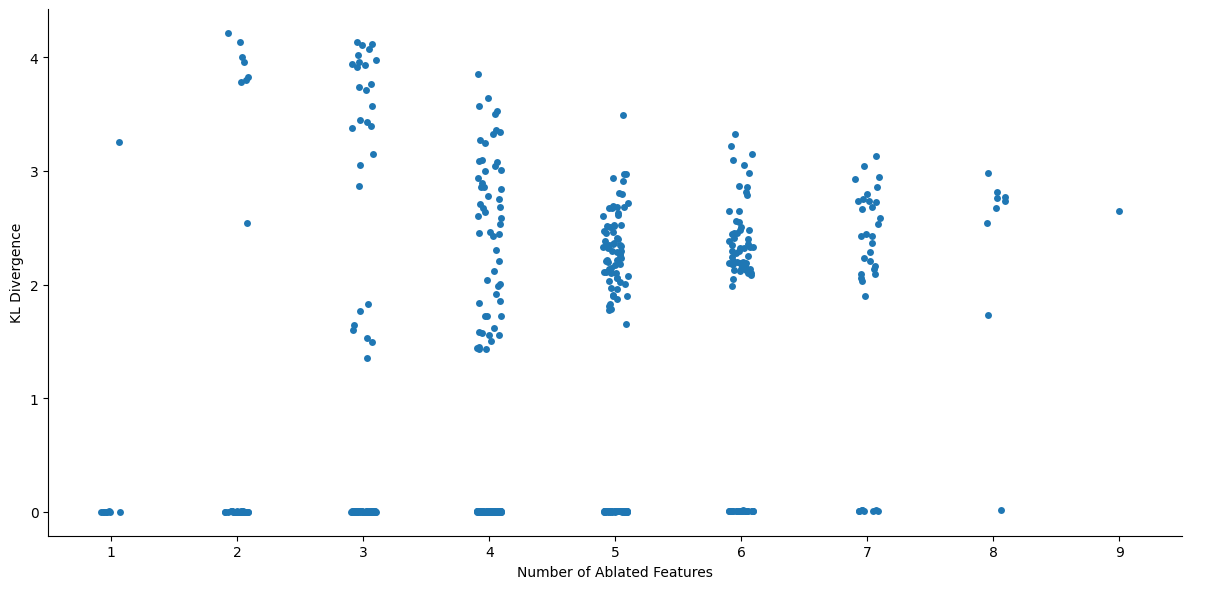

In [54]:
sns.catplot(x="n_features", y="kl_div", data=abl_df, kind="strip", height=6, aspect=2)
plt.xlabel("Number of Ablated Features")
plt.ylabel("KL Divergence")
plt.show()

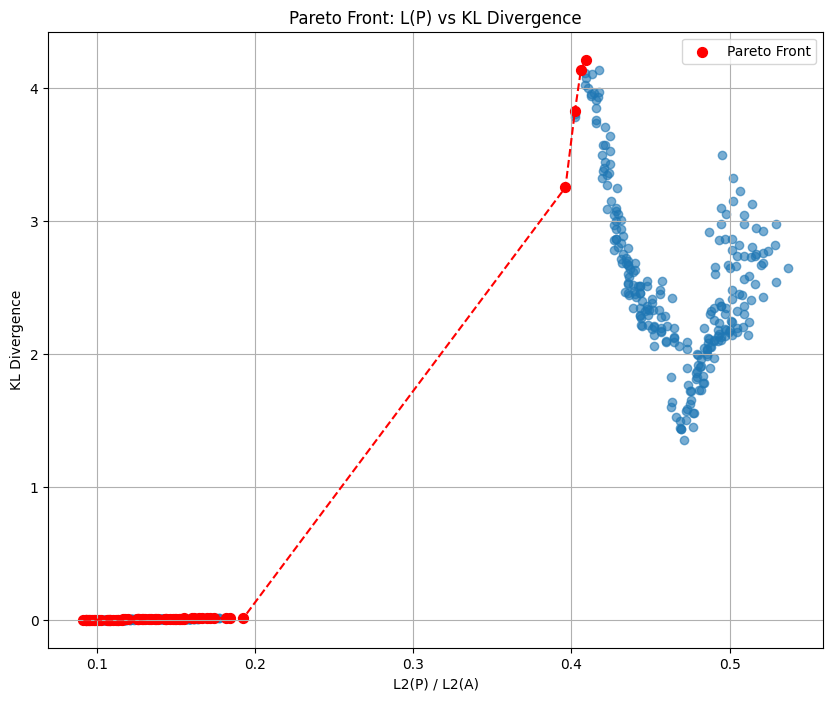

In [55]:
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient


# Assuming you have your data in lists or numpy arrays
lp_values = abl_df["L2(P) / L2(A)"]  # Your L(P) values
kl_div_values = abl_df.kl_div  # Your KL divergence values

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(lp_values, kl_div_values, alpha=0.6)

# Identify Pareto optimal points
costs = np.column_stack((lp_values, -kl_div_values))
pareto_points = is_pareto_efficient(costs)

# Highlight Pareto front
plt.scatter(
    lp_values[pareto_points],
    kl_div_values[pareto_points],
    color="red",
    s=50,
    label="Pareto Front",
)

# Connect Pareto front points
pareto_front = np.column_stack((lp_values[pareto_points], kl_div_values[pareto_points]))
pareto_front = pareto_front[pareto_front[:, 0].argsort()]
plt.plot(pareto_front[:, 0], pareto_front[:, 1], "r--")

# Set labels and title
plt.xlabel("L2(P) / L2(A)")
plt.ylabel("KL Divergence")
plt.title("Pareto Front: L(P) vs KL Divergence")

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [34]:
# abl_df.head()

In [28]:
optimal = abl_df.loc[11].perturbed_act
optimal_kl_div = abl_df.loc[11].kl_div

In [29]:
perturbed_acts_non_pareto = torch.stack(
    abl_df[abl_df.is_pareto_efficient == False].perturbed_act.tolist(), dim=0
)
perturbed_acts_pareto = torch.stack(
    abl_df[abl_df.is_pareto_efficient == True].perturbed_act.tolist(), dim=0
)

In [30]:
max_kl_divs_non_pareto = abl_df[abl_df.is_pareto_efficient == False].kl_div.tolist()
max_kl_divs_pareto = abl_df[abl_df.is_pareto_efficient == True].kl_div.tolist()

In [31]:
def scan_pareto(
    target: Float[torch.Tensor, "... n_ctx d_model"],
    activations: Float[torch.Tensor, "... n_ctx d_model"],
    n_steps: int,
    range: tuple[float, float],
) -> Float[torch.Tensor, "... n_steps 1 d_model"]:
    direction = target - activations
    direction -= torch.mean(direction, dim=-1, keepdim=True)

    act_norm = torch.linalg.vector_norm(activations, dim=-1, keepdim=True)
    dir_norm = torch.linalg.vector_norm(direction, dim=-1, keepdim=True)
    scale = act_norm / dir_norm
    direction *= scale

    perturbed_steps = [
        activations + alpha * direction for alpha in torch.linspace(*range, n_steps)
    ]
    perturbed_activations = torch.cat(perturbed_steps, dim=0)
    return perturbed_activations


def run_perturbation_pareto(cfg: ExperimentConfig, base_ref: Reference, target):
    perturbed_activations = scan_pareto(
        target=target,
        activations=base_ref.act,
        n_steps=cfg.n_steps,
        range=cfg.perturbation_range,
    )
    kl_div = compare(base_ref, perturbed_activations)
    return kl_div

In [32]:
kl_divs_non_pareto = [
    run_perturbation_pareto(cfg, base_ref, perturbed_acts_non_pareto[i, :])
    for i in range(perturbed_acts_non_pareto.shape[0])
]

In [33]:
kl_divs_pareto = [
    run_perturbation_pareto(cfg, base_ref, perturbed_acts_pareto[i, :])
    for i in range(perturbed_acts_pareto.shape[0])
]

In [34]:
kl_div_optimal = run_perturbation_pareto(cfg, base_ref, optimal)

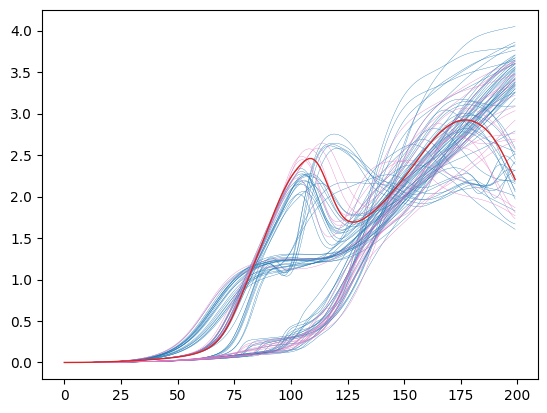

In [35]:
for i, kl_div_nnp in enumerate(kl_divs_non_pareto):
    plt.plot(kl_div_nnp, linewidth="0.25", color="tab:blue")

for kl_div_np in kl_divs_pareto:
    plt.plot(kl_div_np, linewidth="0.25", color="tab:pink")
    # plt.scatter(x=None, y=max_kl_div_pareto, linewidth="2", color="tab:pink")


plt.plot(kl_div_optimal, linewidth="1", color="tab:red")
# plt.scatter(optimal_kl_div, linewidth="2", color="tab:red")

plt.show()

### Checking angles between top-k features and base act

In [141]:
base_act = base_ref.act.squeeze()
feature_acts = sae.encode(base_act)

non_negative_features = (feature_acts > 0).nonzero().squeeze()
sorted_indices = torch.argsort(feature_acts[non_negative_features], descending=False)
sorted_non_negative_features = non_negative_features[sorted_indices]

NameError: name 'original_feature_acts' is not defined

In [ ]:
def cosine_to_angle(cosine_similarity, return_degrees=False):
    # Ensure the input is within the valid range [-1, 1]
    cosine_similarity = torch.clamp(cosine_similarity, -1.0, 1.0)

    # Calculate the angle in radians
    angle_rad = torch.acos(cosine_similarity)

    if return_degrees:
        # Convert to degrees if requested
        angle_deg = torch.rad2deg(angle_rad)
        return angle_deg
    else:
        return angle_rad

In [ ]:
to_ablate_ids = sorted_non_negative_features[:-1]
feature_acts[to_ablate_ids] = 0
perturbed_act = sae.decode(feature_acts).squeeze()

In [ ]:
base_act.norm(), perturbed_act.norm()

torch.Size([768])

In [ ]:
cosine_to_angle(
    F.cosine_similarity(base_act, perturbed_act, dim=0), return_degrees=True
)

tensor(23.8405)

### Feature Importance Distribution Analysis

In [ ]:
# Feature Importance Distribution Analysis:
# Experiment: Compare the distribution of individual feature importances across different orderings.
def get_feature_order(order, feature_acts, feature_idxs):
    if order == "sorted:asc":
        return feature_idxs[torch.argsort(feature_acts[feature_idxs], descending=True)]
    elif order == "sorted:desc":
        return feature_idxs[torch.argsort(feature_acts[feature_idxs], descending=False)]
    elif order == "random":
        return feature_idxs[torch.randperm(len(feature_idxs))]
    else:
        raise NotImplementedError(f"order is not supported: {order}")


def analyze_feature_importance(model, base_ref, sae, order):
    base_act = base_ref.act.squeeze()
    original_feature_acts = sae.encode(base_act)
    logits_base, _ = model.run_with_cache(base_ref.prompt)
    logprobs_base = F.log_softmax(logits_base[:, -1, :], dim=-1)

    non_negative_features = (original_feature_acts > 0).nonzero().squeeze()
    feature_order = get_feature_order(
        order, original_feature_acts, non_negative_features
    )

    individual_kl_divs = []

    for feature_id in feature_order:
        feature_acts = original_feature_acts.clone()
        feature_acts[feature_id] = 0
        perturbed_act = sae.decode(feature_acts)

        def hook(act, hook):
            act[:, -1, :] = perturbed_act

        with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
            logits_pert, _ = model.run_with_cache(base_ref.prompt)

        logprobs_pert = F.log_softmax(logits_pert[:, -1, :], dim=-1)
        kl_div = F.kl_div(
            logprobs_pert, logprobs_base, log_target=True, reduction="batchmean"
        )
        individual_kl_divs.append(kl_div.item())

    return individual_kl_divs

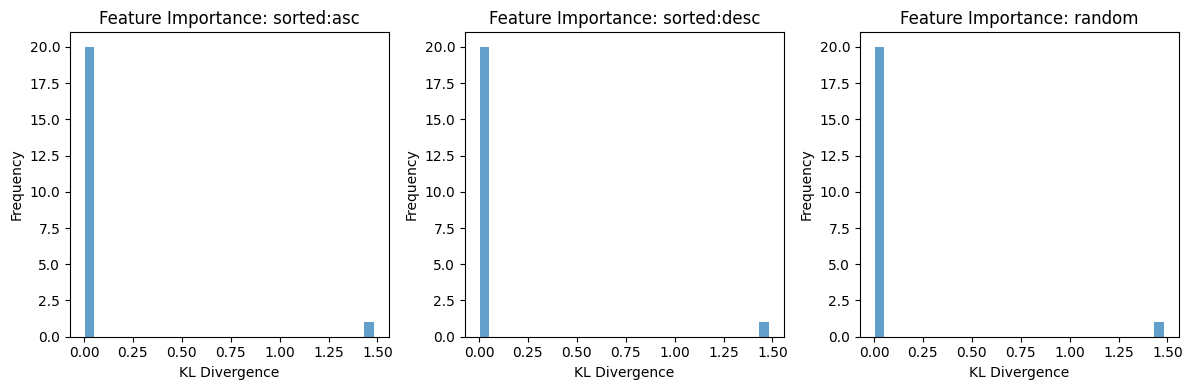

In [ ]:
# Run for different orderings and plot distributions
orderings = ["sorted:asc", "sorted:desc", "random"]
plt.figure(figsize=(12, 4))

for i, order in enumerate(orderings, 1):
    plt.subplot(1, 3, i)
    importance = analyze_feature_importance(model, base_ref, sae, order)
    plt.hist(importance, bins=30, alpha=0.7)
    plt.title(f"Feature Importance: {order}")
    plt.xlabel("KL Divergence")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Mutual Information

In [ ]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression


def compute_mutual_information(model, base_ref, sae, num_samples=10):
    base_act = base_ref.act.squeeze()
    original_feature_acts = sae.encode(base_act)

    # Generate perturbed samples
    perturbed_samples = original_feature_acts.repeat(num_samples, 1)
    noise = torch.randn_like(perturbed_samples) * 0.1  # Adjust noise level as needed
    perturbed_samples += noise

    # Compute model outputs for perturbed samples
    outputs = []

    for sample in perturbed_samples:
        perturbed_act = sae.decode(sample)

        def hook(act, hook):
            act[:, -1, :] = perturbed_act

        with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
            logits, _ = model.run_with_cache(base_ref.prompt)

        outputs.append(logits[:, -1, :].argmax().item())

    # Compute mutual information
    mi_scores = mutual_info_regression(perturbed_samples.numpy(), np.array(outputs))

    return mi_scores

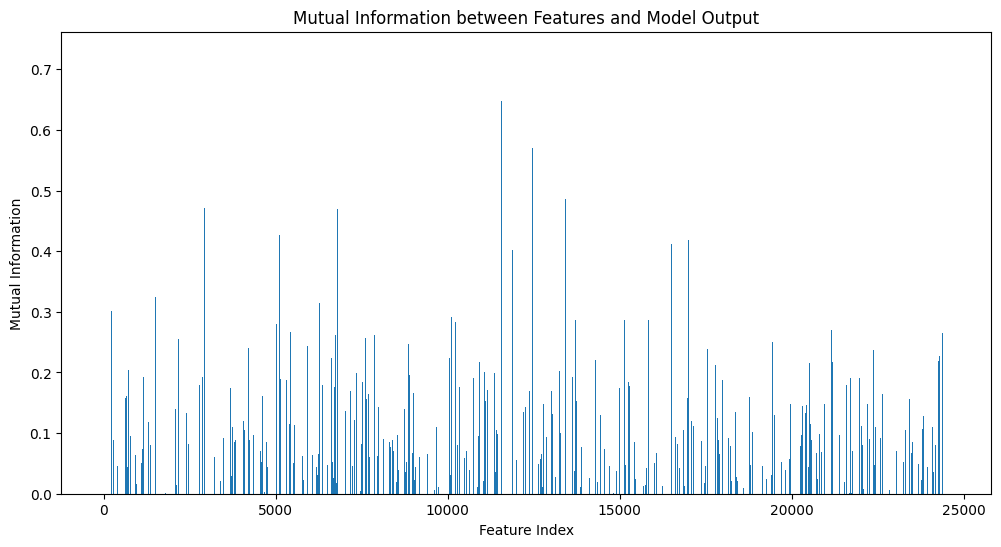

Top 10 features by Mutual Information:
1. Feature 2430: MI = 0.7256
2. Feature 15680: MI = 0.7256
3. Feature 22659: MI = 0.7256
4. Feature 4165: MI = 0.7256
5. Feature 4080: MI = 0.7256
6. Feature 17713: MI = 0.7256
7. Feature 12978: MI = 0.7256
8. Feature 20603: MI = 0.7256
9. Feature 24376: MI = 0.7256
10. Feature 3798: MI = 0.7256


In [ ]:
# Compute and plot MI scores
mi_scores = compute_mutual_information(model, base_ref, sae)

plt.figure(figsize=(12, 6))
plt.bar(range(len(mi_scores)), mi_scores)
plt.title("Mutual Information between Features and Model Output")
plt.xlabel("Feature Index")
plt.ylabel("Mutual Information")
plt.show()

# Print top 10 features by MI score
top_features = np.argsort(mi_scores)[-10:][::-1]
print("Top 10 features by Mutual Information:")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. Feature {feature}: MI = {mi_scores[feature]:.4f}")

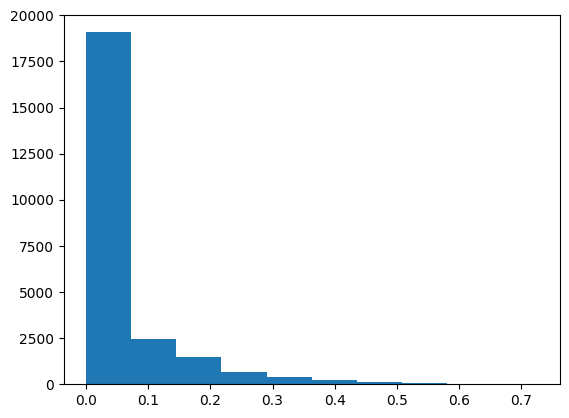

In [ ]:
plt.hist(mi_scores)
plt.show()

### Feature Interaction Analysis
Ablate pairs of features and compare to individual ablations.

In [ ]:
def compute_kl_div_single(model, base_ref, sae, f1):
    base_act = base_ref.act.squeeze()
    feature_acts = sae.encode(base_act)
    logits_base, _ = model.run_with_cache(base_ref.prompt)
    logprobs_base = F.log_softmax(logits_base[:, -1, :], dim=-1)

    feature_acts[f1] = 0
    perturbed_act = sae.decode(feature_acts)

    def hook(act, hook):
        act[:, -1, :] = perturbed_act

    with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
        logits_pert, _ = model.run_with_cache(base_ref.prompt)
        logprobs_pert = F.log_softmax(logits_pert[:, -1, :], dim=-1)

    kl_div = F.kl_div(
        logprobs_pert, logprobs_base, log_target=True, reduction="batchmean"
    )
    return kl_div.item()


def compute_kl_div_pair(model, base_ref, sae, f1, f2):
    base_act = base_ref.act.squeeze()
    feature_acts = sae.encode(base_act)
    logits_base, _ = model.run_with_cache(base_ref.prompt)
    logprobs_base = F.log_softmax(logits_base[:, -1, :], dim=-1)

    feature_acts[np.array([f1, f2])] = 0
    perturbed_act = sae.decode(feature_acts)

    def hook(act, hook):
        act[:, -1, :] = perturbed_act

    with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
        logits_pert, _ = model.run_with_cache(base_ref.prompt)
        logprobs_pert = F.log_softmax(logits_pert[:, -1, :], dim=-1)

    kl_div = F.kl_div(
        logprobs_pert, logprobs_base, log_target=True, reduction="batchmean"
    )
    return kl_div.item()


def analyze_feature_interactions(model, base_ref, sae, feature_order, num_features=5):
    interactions = {}
    for i, f1 in enumerate(feature_order[:num_features]):
        for f2 in feature_order[i + 1 : num_features + 1]:
            individual_effect = compute_kl_div_single(
                model, base_ref, sae, f1
            ) + compute_kl_div_single(model, base_ref, sae, f2)
            paired_effect = compute_kl_div_pair(model, base_ref, sae, f1, f2)
            interactions[(f1.item(), f2.item())] = paired_effect - individual_effect
    return interactions

In [ ]:
base_act = base_ref.act.squeeze()
original_feature_acts = sae.encode(base_act)
non_negative_features = (original_feature_acts > 0).nonzero().squeeze()
sorted_feature_order = non_negative_features[
    torch.argsort(feature_acts[non_negative_features], descending=True)
]

interactions = analyze_feature_interactions(
    model, base_ref, sae, sorted_feature_order, num_features=20
)

# Get unique features from the interactions
features = sorted(set(f for pair in interactions.keys() for f in pair))
n_features = len(features)
feature_to_index = {f: i for i, f in enumerate(features)}
interaction_matrix = np.zeros((n_features, n_features))

# Fill the matrix with interaction values
for (f1, f2), value in interactions.items():
    i, j = feature_to_index[f1], feature_to_index[f2]
    interaction_matrix[i, j] = value
    interaction_matrix[j, i] = value  # Assuming symmetry in interactions

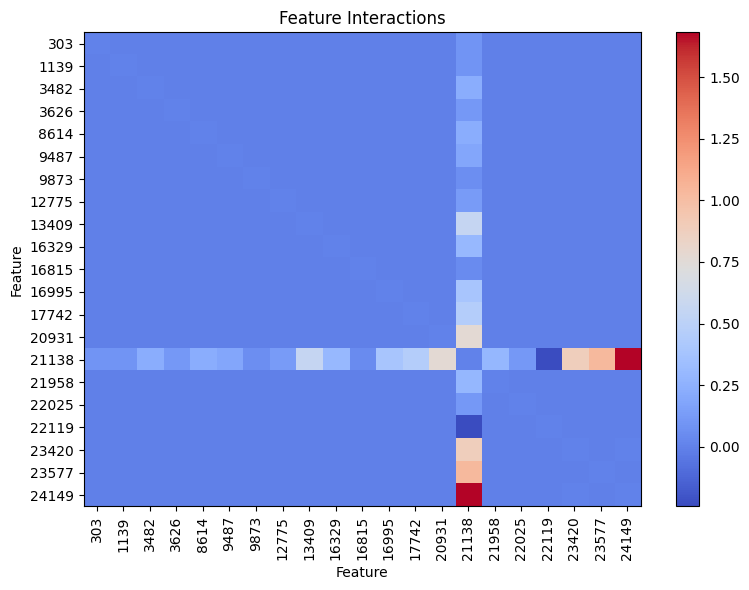

In [ ]:
# Plot the interaction matrix
plt.figure(figsize=(8, 6))
im = plt.imshow(interaction_matrix, cmap="coolwarm", aspect="auto")
plt.colorbar(im)

# Set tick labels to actual feature numbers
plt.xticks(range(n_features), features, rotation=90)
plt.yticks(range(n_features), features)

plt.title("Feature Interactions")
plt.xlabel("Feature")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

### Model Saturation Analysis

Experiment: Track the max probability of the model's output as features are ablated.

In [ ]:
def compute_logits_with_ablation(model, base_ref, sae, feature_idxs):
    base_act = base_ref.act.squeeze()
    feature_acts = sae.encode(base_act)

    feature_acts[feature_idxs] = 0
    perturbed_act = sae.decode(feature_acts)

    def hook(act, hook):
        act[:, -1, :] = perturbed_act

    with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
        logits_pert, _ = model.run_with_cache(base_ref.prompt)

    return logits_pert


def analyze_model_saturation(model, base_ref, sae, feature_order):
    max_probs = []
    for i in range(len(feature_order)):
        logits = compute_logits_with_ablation(model, base_ref, sae, feature_order[:i])
        probs = F.softmax(logits, dim=-1)
        max_probs.append(torch.max(probs).item())

    plt.plot(max_probs)
    plt.title("Max Probability vs. Number of Ablated Features")
    plt.show()

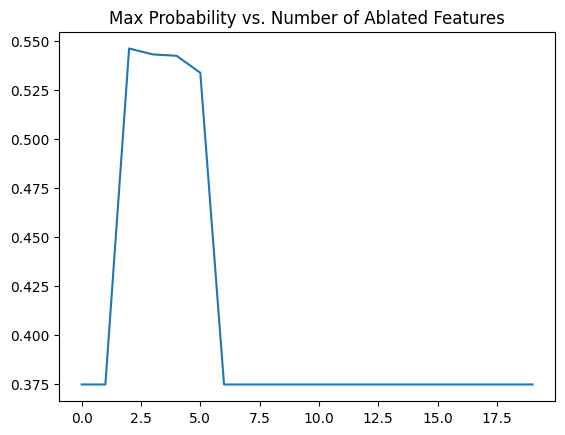

In [ ]:
base_act = base_ref.act.squeeze()
original_feature_acts = sae.encode(base_act)
non_negative_features = (original_feature_acts > 0).nonzero().squeeze()

# random, sorted:asc, sorted:desc
feature_order = get_feature_order(
    "random", original_feature_acts, non_negative_features
)

analyze_model_saturation(model, base_ref, sae, feature_order)

### Activation Strength vs. Importance Correlation
Experiment: Compare feature activation strengths to their individual KL divergence impacts.

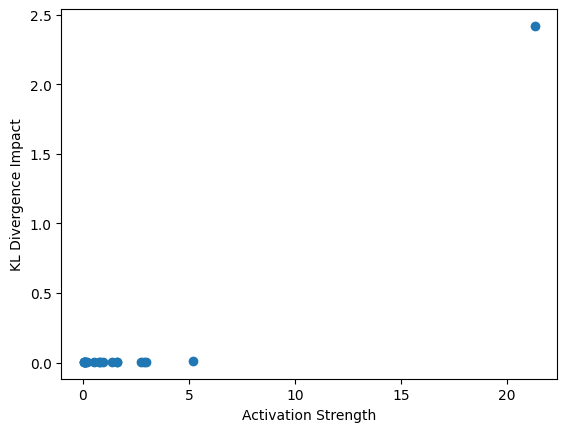

In [ ]:
def activation_vs_importance(model, base_ref, sae):
    base_act = base_ref.act.squeeze()
    feature_acts = sae.encode(base_act)
    non_negative_features = (feature_acts > 0).nonzero().squeeze()
    importances = [
        compute_kl_div_single(model, base_ref, sae, f) for f in non_negative_features
    ]

    plt.scatter(feature_acts[non_negative_features], importances)
    plt.xlabel("Activation Strength")
    plt.ylabel("KL Divergence Impact")
    plt.show()


activation_vs_importance(model, base_ref, sae)